# Mapping patient interactions in psychiatric presentations to a tertiary emergency department
This notebook comprises the code and data analysis for our study:

[reference placeholder - TBA on publication]

Please see our paper for details of our computational methods, and refer to the README for further details about this research project and how to cite this code.

The notebook is organised in four parts corresponding to the subheadings of the results section of the paper, as follows:

#### Part 1: [Characterising patient trajectories as sequences of clinical interactions](#basicstats)
* Constructing an rendering the patient trajectory network.
* Patient trajectory statistics.

#### Part 2: [A network model of interactions reflects clinical team structure and reveals agents important for information flow](#network)
* Constructing the interaction network excluding forbidden edges.
* Visualisation of the interaction network.
* Community detection to show natural division between Emergency Medical and Emergency Psychiatry teams.
* Node centrality measures.

#### Part 3: [Assessing network vulnerabilities and reducing potential impacts via targeted algorithmic addition of edges](#pln)
* Null model for assessing whether PLN betweenness is unexpectedly high.
* Change in local and global efficiency of the network with removal of the PLN node.
* Greedy addition of edges to make network more robust against removal of the PLN node.

#### Part 4: [Identifying types of interactions that precipitate clinical handovers with machine learning on interaction networks](#decision)
* Using a Bernoulli naive Bayes classifier on the adjacency matrix along the patient trajectory to estimate which nodes are most predictive of the decision to refer the patient to the Emergency Psychiatry team.


In [1]:
# Data handling
import os
import csv
import pandas as pd

# Data analysis
import numpy as np
import networkx as nx # need pygraphviz installed for this notebook to run
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.swap import connected_double_edge_swap
from sklearn.model_selection import GroupShuffleSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score, f1_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import cm
if not os.path.exists('figs'):
    os.makedirs('figs')
import matplotlib.font_manager
plt.rcParams["font.size"] = 10
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

# Misc
from tqdm import tqdm
import datetime as dt
from itertools import combinations, permutations

For the generation of the referral network we include the MHOA data.

In [2]:
# Import the cleaned event log
T = pd.read_csv('data.csv')

# Strip spaces from AREA
T['AREA'] = T['AREA'].str.strip()

# Clean up the action column
# Don't need any "TO ..." so remove these
T['ACTION'] = T['ACTION'].fillna('')
action = T['ACTION']

action_clean = []
for a in action:
    if  'TO' in a:
        b = a.split()
        idx = b.index('TO')
        b.pop(idx)
        b.pop(idx) # do this twice to remove the destination tag
        b = ' '.join(b)
        action_clean.append(b)
    else:
        action_clean.append(a)
T['ACTION'] = action_clean

# Create flag for MHOA observations
isMHOA = np.zeros((T.shape[0],),dtype=bool)
isMHOA[range(91,150)] = True
T['isMHOA'] = isMHOA

# Display T
T

,ID,DATE,TIME,AREA,SUBAREA,AGENTS,STORED,ACCESSED,ACTION,PT_AREA,PT_SUBAREA,TEAM,PRESENTATION,isMHOA
0,1,1/01/1900,12:01,ED,RE,TN PT AS,EDIS,EDIS EXTREF,REF EDY,ED,RE,ED,ASSOCIATE,False
1,1,1/01/1900,12:05,ED,RE,TN CON,NaN,EDIS,,ED,WR,ED,ASSOCIATE,False
2,1,1/01/1900,12:10,ED,RE,TN PLN,EDIS,EDIS EXTREF,,ED,WR,EDY,ASSOCIATE,False
3,1,1/01/1900,12:27,ED,WR,PLN PT AS,NaN,PSOLIS RISK,REF MHOA,ED,WR,EDY,ASSOCIATE,False
4,1,1/01/1900,12:35,ED,OTHER,AS PLN,NaN,NaN,,ED,WR,EDY,ASSOCIATE,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,60,3/02/1900,10:05,ED,IR,PLN PT,FILE,FILE EDIS,REF EDY,ED,IR,EDY,UNKNOWN,False
268,60,3/02/1900,10:46,MHOA,OFFICE,PLN YREG YCON,NaN,NaN,REF MHOA,ED,BED,EDY,UNKNOWN,False
269,60,3/02/1900,10:52,MHOA,NSTA,PLN MHOACOORD,MHOAAD,FILE,,ED,BED,MHOA,UNKNOWN,False
270,60,3/02/1900,11:30,MHOA,OFFICE,PLN,EDIS,EDIS,,ED,BED,MHOA,UNKNOWN,False


In [3]:
# Import the agent lookup table
A = pd.read_csv('agents.csv')
A = A[~A['ID'].isin(['MCON','MREG','MHOAHO','CP'])]

# Display A
A

,ID,type,code,colour,label
0,EDIS,RECORD,0,burlywood,Emergency Department\nInformation System
1,EDYHO,RECORD,0,burlywood,Psychiatry\nHandover Sheet
2,EXTREF,RECORD,0,burlywood,External\nReference
3,FILE,RECORD,0,burlywood,Patient File
4,HW,RECORD,0,burlywood,Handwritten\nNote
5,MGMTPLAN,RECORD,0,burlywood,Management\nPlan
6,MHOAAD,RECORD,0,burlywood,MHOA\nAdmissions Form
8,PSOLIS,RECORD,0,burlywood,Psychiatric Services\nOnline Information System
9,RISK,RECORD,0,burlywood,Risk\nAssessment
10,CON,ED_DOC,1,mediumseagreen,Consultant


<a id='basicstats'></a>
## Part 1: Characterising patient trajectories as sequences of clinical interactions

### Patient trajectory network
The patient trajectory network shows the trajectory of a patient from point of admission to discharge as they transition through different clinical units (ED, EDY and MHOA).

This includes all data and is intended as an overview of trajectories for patients with suicide or self-harm risk.

In [4]:
# Import decision lookup table
D = pd.read_csv('decision.csv')

ids = T['ID'].unique()

flow = []

for id in ids:
    # extract data of interest
    data = T[T['ID']==id]
    # create empty trajectory
    traj = []
    # get start point if admission known
    if not (data['PRESENTATION'].values[0] == 'UNKNOWN'):
        traj.append(data['PRESENTATION'].values[0])
    else:
        traj.append(data['TEAM'].values[0])
    # get trajectory
    for index, row in data.iterrows():
        if row['TEAM'] != traj[-1]:
            traj.append(row['TEAM'])
    # add final referral/destination
    if any (data['ACTION']):
        action = next(s for s in reversed(data['ACTION'].values) if s)
        # if final action a referal then remove 'REF'
        if 'REF' in action:
            action = action.split()[-1]
            if action != traj[-1]:
                traj.append(action)
        # if final action admit then split to show type
        if 'ADMIT' in action:
            traj.append('ADMIT')
            traj.append(action.split()[-1])
        # if discharge then allow multiple paths if needed
        if 'DC' in action:
            traj.append('DC')
            a = action.split()[1:]
            if a:
                traj.append(a)
        if 'DAMA' in action:
            traj.append('DAMA')
    flow.append(traj)

# Create decision network
G = nx.DiGraph()
for node in D['AGENT']:
    G.add_node(node)
for traj in flow:
    for i,t in enumerate(traj[1:],1):
        if type(t) is str:
            G.add_edge(traj[i-1],t)
        else:
            for tt in t:
                G.add_edge(traj[i-1],tt)
                
# format G nodes
for i,node in enumerate(D['AGENT']):
    if G.has_node(node):
        nx.set_node_attributes(G,{node:D['LABEL'][i]},'label')
        nx.set_node_attributes(G,{node:D['COLOR'][i]},'color')
        nx.set_node_attributes(G,{node:D['SHAPE'][i]},'shape')
        nx.set_node_attributes(G,{node:D['STYLE'][i]},'style')
        nx.set_node_attributes(G,{node:12},'fontsize')
        nx.set_node_attributes(G,{node:D['LW'][i]},'penwidth')
        for e in G.in_edges(node):
            nx.set_edge_attributes(G,{e:D['STYLE'][D['AGENT']==list(e)[-1]].values[0]},
                                   'style')
            nx.set_edge_attributes(G,{e:D['ARROWHEAD'][D['AGENT']==list(e)[-1]].values[0]},
                                   'arrowhead')
            nx.set_edge_attributes(G,{e:D['LCOLOR'][D['AGENT']==list(e)[-1]].values[0]},
                                   'color')
            nx.set_edge_attributes(G,{e:4},
                                   'penwidth') 

                
G = nx.drawing.nx_agraph.to_agraph(G) 
G.unflatten('-l 1 -f').layout('dot',' '.join(['-Gsize=7.4,6',
                         '-Grankdir=LR',
                         '-Granksep=0.25',
                         '-Gnodesep=0.25',
                         '-Nfontname="Sans-Serif"',
                         '-Nshape=box',
                         '-Nstyle=filled',
                         '-Nstyle=solid']))                                                               
fname = 'figs/decision.svg'
G.draw(fname)

### Interaction information for the ED dataset
Descriptive statistics for presentation type and interactions along patient trajectories.

In [5]:
# Interactions
n_observations = T.shape[0]
print(f'Total number of interactions observed : {n_observations}')
n_observations_ED = T[~T['isMHOA']].shape[0]
print(f'Interactions in ED: {n_observations_ED}')
n_observations_MHOA = T[T['isMHOA']].shape[0]
print(f'Interactions in MHOA: {n_observations_MHOA}')

# Patients
n_pt = len(T['ID'].unique())
print(f'Total number of patients : {n_pt}')
n_pt_ED = len(T[~T['isMHOA']]['ID'].unique())
print(f'Total number of patients in ED: {n_pt_ED}')
n_pt_MHOA = len(T[T['isMHOA']]['ID'].unique())
print(f'Total number of patients in MHOA: {n_pt_MHOA}')

# Agents (nodes)
aa = []
for (agents,stored,accessed) in zip(T['AGENTS'].values,T['STORED'].values,T['ACCESSED'].values):
    a = agents.split()
    if isinstance(stored,str):
        a += stored.split()
    if isinstance(accessed,str):
        a += accessed.split()
    a = list(set(a))
    aa += a
aa = np.unique(aa)
n_agents = len(aa)
print(f'Total agent types: {n_agents}')

aa = []
TT = T[~T['isMHOA']]
for (agents,stored,accessed) in zip(TT['AGENTS'].values,TT['STORED'].values,TT['ACCESSED'].values):
    a = agents.split()
    if isinstance(stored,str):
        a += stored.split()
    if isinstance(accessed,str):
        a += accessed.split()
    a = list(set(a))
    aa += a
aa = np.unique(aa)
n_agents_ED = len(aa)
print(f'Agent types in ED: {n_agents_ED}')
print(f'Agent types only observed in MHOA: {n_agents - n_agents_ED}')

# Length of trajectories observed in ED only (including incomplete trajectories)
pt = np.unique(T['ID'][:91].to_list() + T['ID'][150:].to_list())
pt = T[~T['isMHOA']]['ID'].unique()
traj_time = []
for p in pt:
    idx = T['ID'] == p
    TT = T[idx].copy().reset_index(inplace=False,drop=True)
    t0 = dt.datetime.strptime(TT['DATE'][0] + ' ' + TT['TIME'][0], '%d/%m/%Y %H:%M')
    t1 = dt.datetime.strptime(TT['DATE'].iloc[-1] + ' ' + TT['TIME'].iloc[-1], '%d/%m/%Y %H:%M')
    t = t1 - t0
    traj_time.append(t.total_seconds()/60)
print(f'Median trajectory time observed in ED (including incomplete): {np.median(traj_time):.0f} minutes')


Total number of interactions observed : 272
Interactions in ED: 213
Interactions in MHOA: 59
Total number of patients : 43
Total number of patients in ED: 36
Total number of patients in MHOA: 7
Total agent types: 31
Agent types in ED: 27
Agent types only observed in MHOA: 4
Median trajectory time observed in ED (including incomplete): 88 minutes


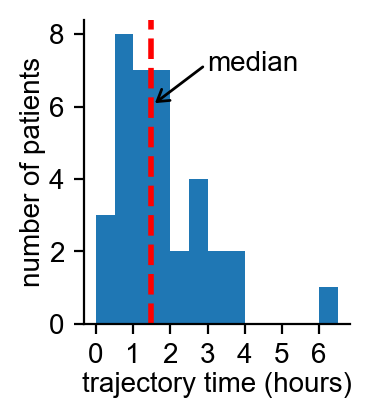

In [6]:
# Length of trajectories observed in ED only (including incomplete trajectories)
pt = T[~T['isMHOA']]['ID'].unique()
traj_time = []
for p in pt:
    idx = T['ID'] == p
    TT = T[idx].copy().reset_index(inplace=False,drop=True)
    t0 = dt.datetime.strptime(TT['DATE'][0] + ' ' + TT['TIME'][0], '%d/%m/%Y %H:%M')
    t1 = dt.datetime.strptime(TT['DATE'].iloc[-1] + ' ' + TT['TIME'].iloc[-1], '%d/%m/%Y %H:%M')
    t = t1 - t0
    traj_time.append(t.total_seconds()/60/60)


# Plot trajectory time
fig,ax = plt.subplots(
    figsize=(1.75,2),
    # tight_layout=False,
    
)
ax.set_position([0.22,0.22,0.76,0.76])

ax.hist(
    traj_time,
    bins=np.arange(0,7,0.5)
)
ax.axvline(np.median(traj_time),color='r',ls='--',lw=2,label='median')
# Format axes
# ax.legend(handletextpad=0.1)
ax.annotate('median', xy=(np.median(traj_time), 6), xytext=(3, 7),
            arrowprops=dict(facecolor='black',arrowstyle='->,head_width=0.25',relpos=(0,0.5)),
            bbox=dict(pad=0.1, fc="none", ec="none")
)
ax.set_xticks(np.arange(0,7,1))
ax.set_yticks(np.arange(0,9,2))
ax.set_ylabel('number of patients',labelpad=1)
ax.set_xlabel('trajectory time (hours)',labelpad=1);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/traj_times_histogram.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

In [7]:
print(f'Trajectory time has median {np.median(traj_time):.2f} hours, spanning {np.percentile(traj_time,5):.2f} to {np.percentile(traj_time,95):.2f} hours (5th and 95th percentiles of the data)')

Trajectory time has median 1.47 hours, spanning 0.33 to 3.82 hours (5th and 95th percentiles of the data)


## Part 1C: Presentation type and interactions in ED

### Presentation type

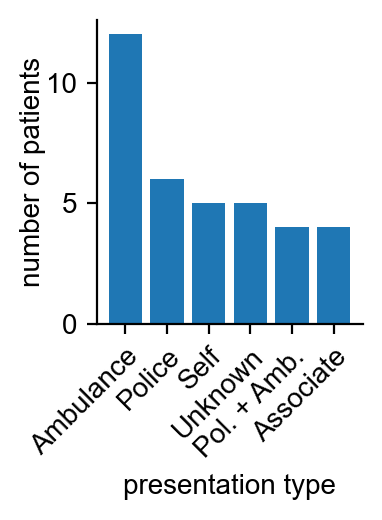

In [8]:
T = T[~T['isMHOA']]

# Plot presentation type histogram
filt_data = T.groupby('ID').first()['PRESENTATION'].value_counts()
y = filt_data.values
x = range(len(y))
lbl = {
    'UNKNOWN':'Unknown',
    'BIBA':'Ambulance',
    'BIBP': 'Police',
    'BIBPA':'Pol. + Amb.',
    'ASSOCIATE':'Associate',
    'SELF':'Self'
}
fig,ax = plt.subplots(
    figsize=(1.75,2.5),
)
ax.set_position([0.22,(0.22+0.25)/1.25,0.76,0.76/1.25])

ax.bar(x,y)
# Format axes
ax.set_xticks(x)
ax.set_xticklabels(
    [lbl[key] for key in filt_data.keys()],
    rotation=45,
    ha='right',
    rotation_mode="anchor"
)
ax.set_xlabel('presentation type',labelpad=4)
ax.set_ylabel('number of patients',labelpad=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/presentation_histogram.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)




### Interactions rates - full trajectory
There are no differences in interaction rates or rate of involvement of clinical staff over the full length of observed trajectories.

Median number of interactions per patient observed in ED (including incomplete): 5
Median number of agent types per patient observed in ED (including incomplete): 4


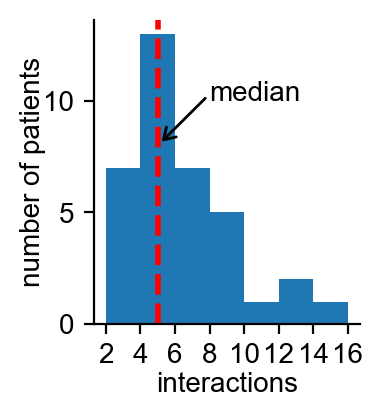

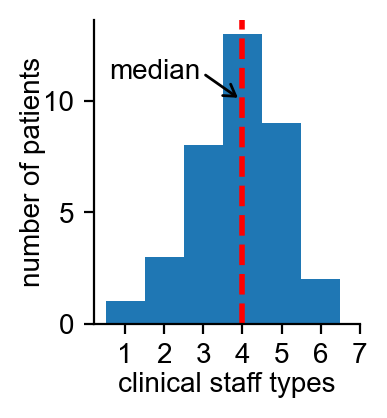

In [9]:
PT = T['ID'].unique()

clinical = ['ED_DOC','NURSE','ED_Y','MHOA_Y']

num_interactions = []
num_clinical = []

for pt in PT:
    idx = T['ID'] == pt
    TT = T[idx]
    # Number of interactions
    num_interactions.append(TT.shape[0])
    # Number of staff types involved
    agents = ' '.join(TT['AGENTS'].to_list()).split()
    agents = [
        a
        for a
        in agents
        if (A[A['ID']==a]['type'].iloc[0] in clinical)                        
    ]
    num_clinical.append(np.unique(agents).size)

# Plots interactions histogram
fig,ax = plt.subplots(figsize=(1.75,2))
ax.set_position([0.22,0.22,0.76,0.76])
bins = np.arange(2,18,2)
ax.hist(
    num_interactions,
    bins=bins
)
ax.axvline(np.median(num_interactions),color='r',ls='--',lw=2,label='median')
print(f'Median number of interactions per patient observed in ED (including incomplete): {np.median(num_interactions):.0f}')

# Format axes
# ax.legend(handletextpad=0.1)
ax.annotate('median', xy=(np.median(num_interactions), 8), xytext=(8, 10),
            arrowprops=dict(facecolor='black',arrowstyle='->,head_width=0.25',relpos=(0,0.5)),
            bbox=dict(pad=0.1, fc="none", ec="none")
)
ax.set_xticks(bins)
ax.set_xlabel('interactions',labelpad=1)
ax.set_ylabel('number of patients',labelpad=-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/interactions_histogram.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

# Plot agent types histogram
fig,ax = plt.subplots(figsize=(1.75,2))
ax.set_position([0.22,0.22,0.76,0.76])
bins = np.arange(0.5,7.5,1)
ax.hist(
    num_clinical,
    bins=bins
)
ax.axvline(np.median(num_clinical),color='r',ls='--',lw=2,label='median')
print(f'Median number of agent types per patient observed in ED (including incomplete): {np.median(num_clinical):.0f}')

# Format axes
# ax.legend(handletextpad=0.1,loc='upper left')
ax.annotate('median', xy=(np.median(num_clinical), 10), xytext=(0.6, 11),
            arrowprops=dict(facecolor='black',arrowstyle='->,head_width=0.25',relpos=(1,0.5)),
            bbox=dict(pad=0.1, fc="none", ec="none")
)
ax.set_xticks(bins+0.5)
ax.set_xlabel('clinical staff types',labelpad=1)
ax.set_ylabel('number of patients',labelpad=-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/agents_histogram.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

In [10]:
print(f'Number of interactions has median {np.median(num_interactions):.2f}, spanning {np.percentile(num_interactions,5,method="higher"):.2f} to {np.percentile(num_interactions,95,method="lower"):.2f} (5th and 95th percentiles of the data)')
print(f'Number of agents has median {np.median(num_clinical):.2f}, spanning {np.percentile(num_clinical,5,method="higher"):.2f} to {np.percentile(num_clinical,95,method="lower"):.2f} (5th and 95th percentiles of the data)')

Number of interactions has median 5.00, spanning 2.00 to 12.00 (5th and 95th percentiles of the data)
Number of agents has median 4.00, spanning 2.00 to 5.00 (5th and 95th percentiles of the data)


<a id='network'></a>
## Part 2: A network model of interactions reflects clinical team structure and reveals agents important for information flow

We construct an interaction network to investigate systems-level properties of the ED operations for patients with potential risk of suicide or self harm. This network includes all clinical staff, external professionals (GPs, police, ambulance, etc), records systems (the patient file, EDIS, PSOLIS etc.), and the patient and patient's associate/s.

### Forbidden edges
There is an intrinsic structure in this network that is not explicitly reflected in the data. For example, an interaction may involve a member of clinical staff, the patient, and the patient file which the staff member is reading or adding to. Records systems such as the patient file are never accessed by patients or non-clinical staff. This is one of several types of forbidden edges in the network.

The first step in constructing the network is therefore to defining a list of forbidden edges, as implemented below:

In [11]:
# Create list of forbidden edges
forbidden = []

# RECORD cannot connect to RECORD
records = A[A['type']=='RECORD']['ID'].to_list()
records.sort()
for pair in combinations(records,2):
    forbidden.append(pair)

# RECORD cannot connect to PUBLIC or EXTERNAL
nonstaff = A[A['type'].isin(['PUBLIC','EXTERNAL'])]['ID'].to_list()
for agent in nonstaff:
    for record in records:
        pair = tuple(sorted([agent,record]))
        forbidden.append(pair)

# PSOLIS can only connect to EDY
notEDY = A[~A['type'].isin(['ED_Y','MHOA_Y'])]['ID'].to_list()
for agent in notEDY:
    pair = tuple(sorted([agent,'PSOLIS']))
    forbidden.append(pair)

# EDYHO can only connect to EDY
for agent in notEDY:
    pair = tuple(sorted([agent,'EDYHO']))
    forbidden.append(pair)

forbidden = list(set(forbidden))

### Network construction
To construct the network we enumerate an edge list by looping over all of the interaction events and removing forbidden edges.

In [12]:
E = [] # temporary edge list for network creation          

# Loop over all events and enumerate all observed unique pairs of agents and records
for (agents,stored,accessed) in zip(T['AGENTS'].values,T['STORED'].values,T['ACCESSED'].values):
    a = agents.split()
    if isinstance(stored,str):
        a += stored.split()
    if isinstance(accessed,str):
        a += accessed.split()
    a = list(set(a))
    a.sort() # edges are bi-directional so sorting makes filtering easier
    for pair in combinations(a,2):
        if pair not in forbidden:
            E.append(pair)

# Create network
G = nx.from_edgelist(E)

### Community detection
We expect that the observed interaction network should reflect the inherent division between the ED clinical team and the ED Psych team.

To test this we use community detection via greedy modularity based clustering. We visualise this result with a spring embedding of the network structure with nodes coloured based on community membership.

In [13]:
communities = greedy_modularity_communities(G)
print(f'Number of communities: {len(communities)}')

Number of communities: 2


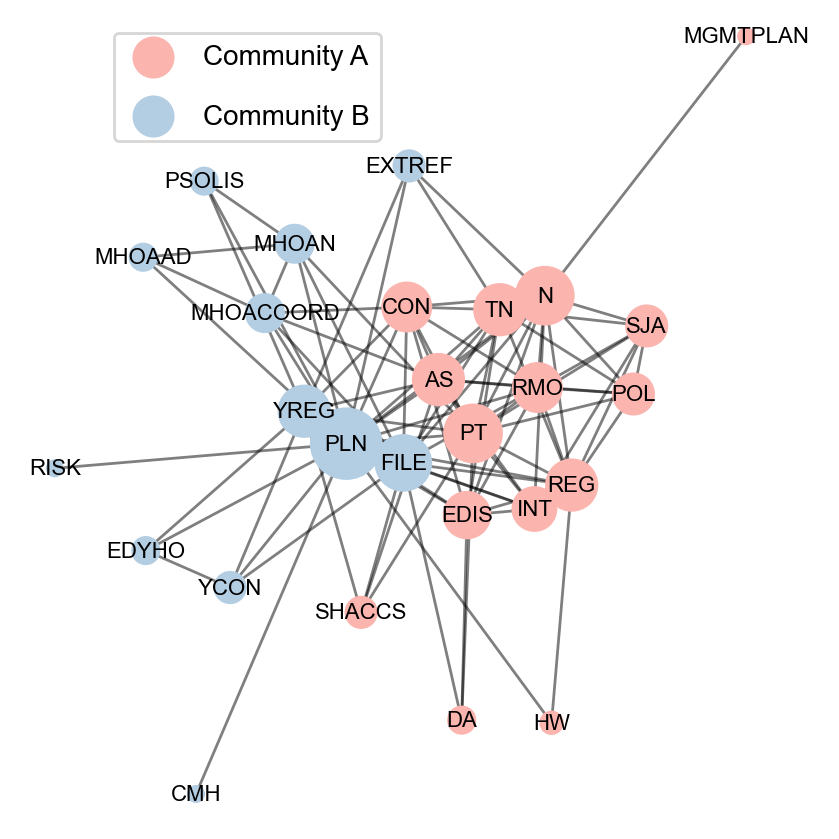

In [14]:
fig,ax = plt.subplots(
    figsize=[4,4],
    # tight_layout=False,
    facecolor='white'
)

ax.set_position([0,0,1,1])

pos = nx.spring_layout(G,seed=3) # seed selected for visualisation

nx.draw_networkx_edges(G, pos, ax=ax, edge_color='k',
                       alpha=0.5, width= 1)
# nx.draw_networkx(G, pos, ax=ax,
#                  node_color='none', edge_color='none',
#                  with_labels=False)

label = [
    'Community A',
    'Community B'
]

node_colors = cm.Pastel1(range(2))
for i,(com,node_color) in enumerate(zip(communities,node_colors)):
    sz = np.array(G.degree(com))[:,1].astype(float)
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=com,
        node_color=node_color.reshape(1,4),
        node_size=sz*30,
        ax=ax
    )
    ax.scatter(
        None,
        None,
        s=200,
        color=node_color.reshape(1,4),
        label=label[i]
    )
nx.draw_networkx_labels(
    G,
    pos,
    font_size=8,
    font_color='k',
    font_family='sans-serif',
    font_weight='normal',
    alpha=None,
    bbox=None,
    horizontalalignment='center',
    verticalalignment='center',
    ax=ax,
)

ax.legend(
    fontsize=10,
    labelspacing=1.2,
    loc='upper left',
    bbox_to_anchor=(0.1, 1),
)
ax.set_xlim(-1.1,1.2)
ax.set_ylim(-0.8,0.8)
ax.axis('off')

# Save figure
fname = "figs/network_communities.pdf"
fig.savefig(
    fname,
    format='pdf',
    # bbox_inches='tight',
    # pad_inches=0,
)

### Quantifying ED network topology
Below we plot degree, betweenness, closeness and the clustering coefficient for each agent.

We also compute the global efficiency for later comparisons.

These results suggest that the PLN is a critical agent in the system, having the highest centrality by degree, betweenness and closeness centrality.

The PLN also has very low clustering. This suggests the hypothesis that the system might be made robust by targeted addition of edges (i.e., increase lines of communication between other between other agents/information sources) which we address later.

In [15]:
# Construct network from edge list
G = nx.from_edgelist(E)

# Compute local measures
degree = dict(G.degree)
btwn = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)
cluster = nx.cluster.clustering(G)

# Compute global measures
transitivity = nx.transitivity(G)
path_length = nx.average_shortest_path_length(G)
global_eff = nx.global_efficiency(G)

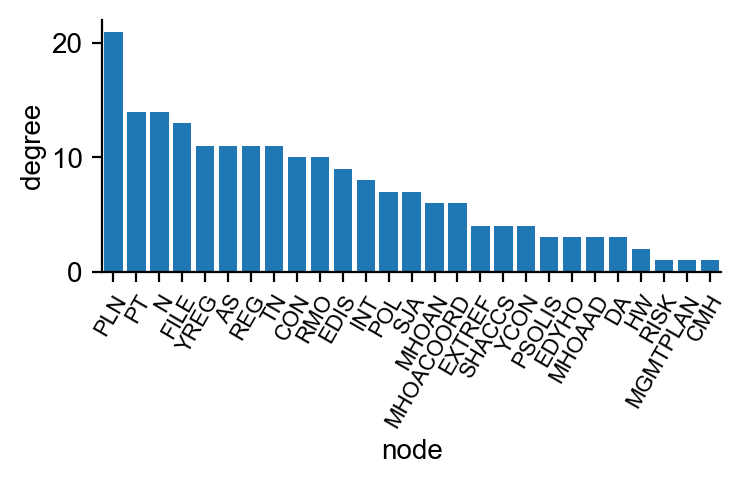

In [16]:
fig,ax = plt.subplots(
    figsize=(3.6,2.25)
)

ax.set_position([0.12,0.42,0.86,0.56])


idx = np.argsort(-np.fromiter(degree.values(),dtype=float))
y = np.array(list(degree.values()))[idx]
lbl = np.array(list(degree.keys()))[idx]
x = range(len(degree))
ax.bar(x, y, align='center')

# Format axes
ax.set_xticks(x)
ax.set_xticklabels(
    lbl,
    rotation=60,
    fontsize=8,
    ha='right',
    rotation_mode='anchor'
)
ax.set_xlabel('node',labelpad=3)
ax.set_ylabel('degree',labelpad=2)
ax.set_xlim(x[0]-0.5,x[-1]+0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/net_degree.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)




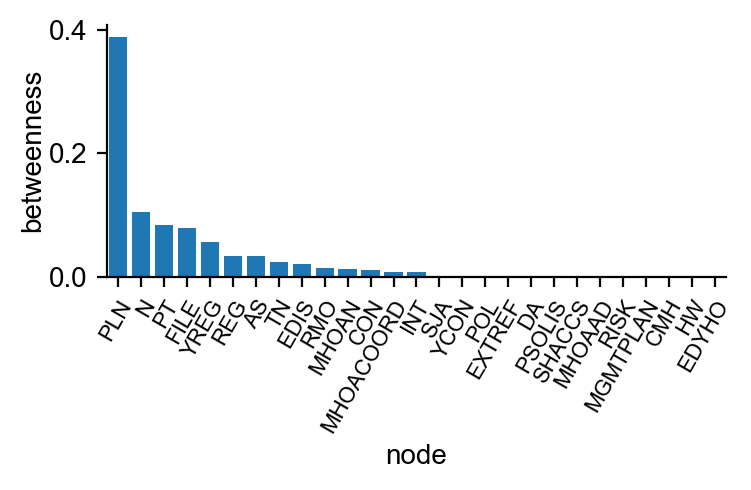

In [17]:
fig,ax = plt.subplots(
    figsize=(3.6,2.25)
)

ax.set_position([0.12,0.42,0.86,0.56])


idx = np.argsort(-np.fromiter(btwn.values(),dtype=float))
y = np.array(list(btwn.values()))[idx]
lbl = np.array(list(btwn.keys()))[idx]
x = range(len(btwn))
ax.bar(x, y, align='center');

# Format axes
ax.set_xticks(x)
ax.set_xticklabels(
    lbl,
    rotation=60,
    fontsize=8,
    ha='right',
    rotation_mode='anchor'
)
ax.set_xlabel('node',labelpad=3)
ax.set_ylabel('betweenness',labelpad=1)
ax.set_xlim(x[0]-0.5,x[-1]+0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/net_btwn.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)


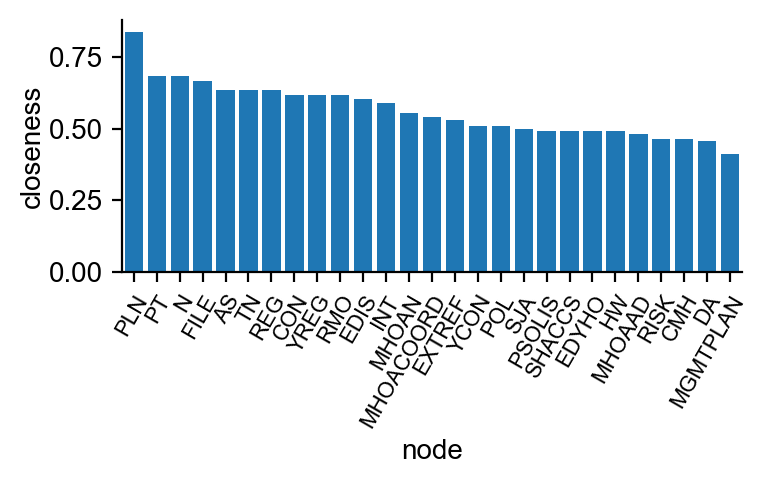

In [18]:
fig,ax = plt.subplots(
    figsize=(3.6,2.25)
)

ax.set_position([0.12,0.42,0.86,0.56])


idx = np.argsort(-np.fromiter(close.values(),dtype=float))
y = np.array(list(close.values()))[idx]
lbl = np.array(list(close.keys()))[idx]
x = range(len(close))
ax.bar(x, y, align='center');

# Format axes
ax.set_xticks(x)
ax.set_xticklabels(
    lbl,
    rotation=60,
    fontsize=8,
    ha='right',
    rotation_mode='anchor'
)
ax.set_xlabel('node',labelpad=3)
ax.set_ylabel('closeness',labelpad=1)
ax.set_xlim(x[0]-0.5,x[-1]+0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/net_close.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)


<a id='pln'></a>
## Part 3: Assessing network vulnerabilities and reducing potential impacts via targeted algorithmic addition of edges

### Creating a null model to assess network measures

To create a null model we use a connected double edge swap. This randomises network connections while retaining the degree of each node. The `networkx` package has a `connected_double_edge_swap` function. However, our network has a set of forbidden edges (i.e. the patient file cannot "interact" with another record, or a patient etc.). Below we have modified this function to accept a set of forbidden edges. If a forbidden swap occurs it is reversed and a different random swap is attempted.

In [19]:
@nx.utils.py_random_state(4)
def connected_double_edge_swap_forbid(G, nswap=1, _window_threshold=3, forbidden=[], seed=None):
    """Attempts the specified number of double-edge swaps in the graph `G`.
    
    *** MODIFIED by Michael H McCullough ,michael.mccullough@anu.edu.au>.
    This version accepts as input a list of forbidden edges that are not
    allowed when shuffling the network.

    NetworkX is distributed with the 3-clause BSD license.

    Copyright (C) 2004-2023, NetworkX Developers
    Aric Hagberg <hagberg@lanl.gov>
    Dan Schult <dschult@colgate.edu>
    Pieter Swart <swart@lanl.gov>
    All rights reserved.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are
    met:

        * Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.

        * Redistributions in binary form must reproduce the above
        copyright notice, this list of conditions and the following
        disclaimer in the documentation and/or other materials provided
        with the distribution.

        * Neither the name of the NetworkX Developers nor the names of its
        contributors may be used to endorse or promote products derived
        from this software without specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
    "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
    LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
    A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
    OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
    SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
    LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
    DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
    THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
    (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
    OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

    A double-edge swap removes two randomly chosen edges `(u, v)` and `(x,
    y)` and creates the new edges `(u, x)` and `(v, y)`::

     u--v            u  v
            becomes  |  |
     x--y            x  y

    If either `(u, x)` or `(v, y)` already exist, then no swap is performed
    so the actual number of swapped edges is always *at most* `nswap`.

    Parameters
    ----------
    G : graph
       An undirected graph

    nswap : integer (optional, default=1)
       Number of double-edge swaps to perform

    _window_threshold : integer

       The window size below which connectedness of the graph will be checked
       after each swap.

       The "window" in this function is a dynamically updated integer that
       represents the number of swap attempts to make before checking if the
       graph remains connected. It is an optimization used to decrease the
       running time of the algorithm in exchange for increased complexity of
       implementation.

       If the window size is below this threshold, then the algorithm checks
       after each swap if the graph remains connected by checking if there is a
       path joining the two nodes whose edge was just removed. If the window
       size is above this threshold, then the algorithm performs do all the
       swaps in the window and only then check if the graph is still connected.

    forbidden : list
       List of forbidden edges.

    seed : integer, random_state, or None (default)
       Indicator of random number generation state.
       See :ref:`Randomness<randomness>`.

    Returns
    -------
    int
       The number of successful swaps

    Raises
    ------

    NetworkXError

       If the input graph is not connected, or if the graph has fewer than four
       nodes.

    Notes
    -----

    The initial graph `G` must be connected, and the resulting graph is
    connected. The graph `G` is modified in place.

    References
    ----------
    .. [1] C. Gkantsidis and M. Mihail and E. Zegura,
           The Markov chain simulation method for generating connected
           power law random graphs, 2003.
           http://citeseer.ist.psu.edu/gkantsidis03markov.html
        """
    if not nx.is_connected(G):
        raise nx.NetworkXError("Graph not connected")
    if len(G) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    n = 0
    swapcount = 0
    deg = G.degree()
    # Label key for nodes
    dk = list(n for n, d in G.degree())
    cdf = nx.utils.cumulative_distribution(list(d for n, d in G.degree()))
    discrete_sequence = nx.utils.discrete_sequence
    window = 1
    while n < nswap:
        wcount = 0
        swapped = []
        # If the window is small, we just check each time whether the graph is
        # connected by checking if the nodes that were just separated are still
        # connected.
        if window < _window_threshold:
            # This Boolean keeps track of whether there was a failure or not.
            fail = False
            while wcount < window and n < nswap:
                # Pick two random edges without creating the edge list. Choose
                # source nodes from the discrete degree distribution.
                (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
                # If the source nodes are the same, skip this pair.
                if ui == xi:
                    continue
                # Convert an index to a node label.
                u = dk[ui]
                x = dk[xi]
                # Choose targets uniformly from neighbors.
                v = seed.choice(list(G.neighbors(u)))
                y = seed.choice(list(G.neighbors(x)))
                # If the target nodes are the same, skip this pair.
                if v == y:
                    continue


                # If the target pairs are forbidden, skip this pair.
                forbid1 = tuple(sorted([u,x])) in forbidden
                forbid2 = tuple(sorted([v,y])) in forbidden
                if forbid1 or forbid2:
                    continue


                if x not in G[u] and y not in G[v]:
                    G.remove_edge(u, v)
                    G.remove_edge(x, y)
                    G.add_edge(u, x)
                    G.add_edge(v, y)
                    swapped.append((u, v, x, y))
                    swapcount += 1
                n += 1
                # If G remains connected...
                if nx.has_path(G, u, v):
                    wcount += 1
                # Otherwise, undo the changes.
                else:
                    G.add_edge(u, v)
                    G.add_edge(x, y)
                    G.remove_edge(u, x)
                    G.remove_edge(v, y)
                    swapcount -= 1
                    fail = True
            # If one of the swaps failed, reduce the window size.
            if fail:
                window = int(math.ceil(window / 2))
            else:
                window += 1
        # If the window is large, then there is a good chance that a bunch of
        # swaps will work. It's quicker to do all those swaps first and then
        # check if the graph remains connected.
        else:
            while wcount < window and n < nswap:
                # Pick two random edges without creating the edge list. Choose
                # source nodes from the discrete degree distribution.
                (ui, xi) = nx.utils.discrete_sequence(2, cdistribution=cdf)
                # If the source nodes are the same, skip this pair.
                if ui == xi:
                    continue
                # Convert an index to a node label.
                u = dk[ui]
                x = dk[xi]
                # Choose targets uniformly from neighbors.
                v = seed.choice(list(G.neighbors(u)))
                y = seed.choice(list(G.neighbors(x)))
                # If the target nodes are the same, skip this pair.
                if v == y:
                    continue

                # If the target pairs are forbidden, skip this pair.
                forbid1 = tuple(sorted([u,x])) in forbidden
                forbid2 = tuple(sorted([v,y])) in forbidden
                if forbid1 or forbid2:
                    continue

                if x not in G[u] and y not in G[v]:
                    G.remove_edge(u, v)
                    G.remove_edge(x, y)
                    G.add_edge(u, x)
                    G.add_edge(v, y)
                    swapped.append((u, v, x, y))
                    swapcount += 1
                n += 1
                wcount += 1
            # If the graph remains connected, increase the window size.
            if nx.is_connected(G):
                window += 1
            # Otherwise, undo the changes from the previous window and decrease
            # the window size.
            else:
                while swapped:
                    (u, v, x, y) = swapped.pop()
                    G.add_edge(u, v)
                    G.add_edge(x, y)
                    G.remove_edge(u, x)
                    G.remove_edge(v, y)
                    swapcount -= 1
                window = int(math.ceil(window / 2))
    return swapcount

### Network measures on the null model
We generate 1000 random null model networks while enforcing degree, connectivity (i.e. network remains connected) and forbidden edges.

Each random network is generated with 20000 attempted swaps, which results in a mean number of successful swaps in the order of 1900 and minimum around  1700 (varies with the sample of random seeds).

We show the distribution of betweenness centrality using violin plots for the ten agents with the largest betweenness in the true data.

The code block below computes and then saves the results of the shuffles. If these results have been generated in a previous run they are reloaded rather than being recomputed.

In [20]:
fname = 'network_shuffle_results.npz'
if not os.path.isfile(fname):
    print(
        "Intermediate results data do not exist... Computing..."
    )
    btwn_rand = []
    close_rand = []
    cluster_rand = []
    transitivity_rand = []
    path_length_rand = []
    global_eff_rand = []
    local_eff_rand = []
    n_swap = np.zeros(1000)
    for i in tqdm(range(1000)):
        G = nx.from_edgelist(E)
        n_swap[i] = connected_double_edge_swap_forbid(G, nswap=20000,
                                                      _window_threshold=1,
                                                      forbidden=forbidden,seed=None)
        b = nx.betweenness_centrality(G)
        btwn_rand.append(np.fromiter(b.values(),dtype=float))
        c = nx.closeness_centrality(G)
        close_rand.append(np.fromiter(c.values(),dtype=float))
        cl = nx.cluster.clustering(G)
        cluster_rand.append(np.fromiter(cl.values(),dtype=float))
        transitivity_rand.append(nx.transitivity(G))
        path_length_rand.append(nx.average_shortest_path_length(G))
        global_eff_rand.append(nx.global_efficiency(G))
    np.savez(
        fname,
        btwn_rand,
        close_rand,
        cluster_rand,
        transitivity_rand,
        path_length_rand,
        global_eff_rand,
        local_eff_rand,
    )
else:
    print(
        "Intermediate results data exists."
    )
    with np.load(fname) as data:
        btwn_rand = data['arr_0']


Intermediate results data exists.


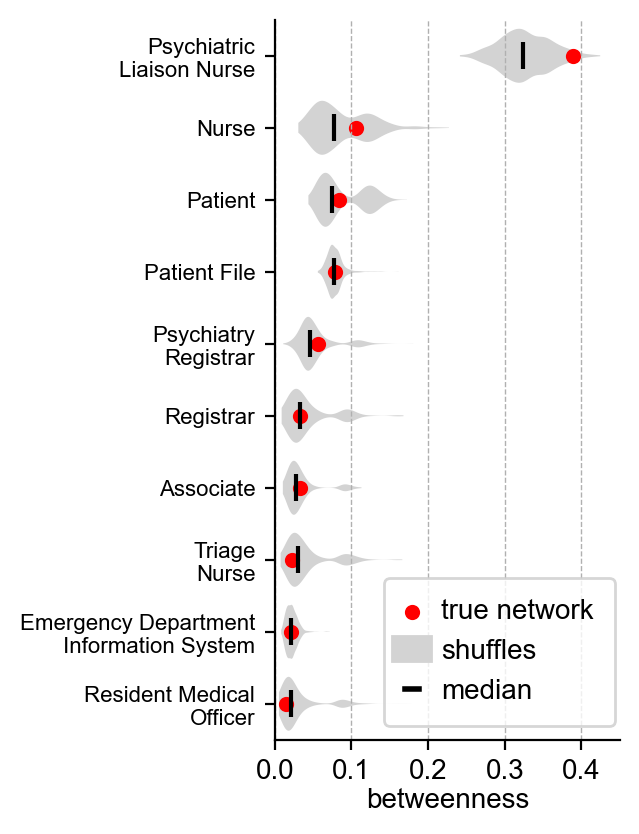

In [21]:
label_dict = dict(zip(A['ID'],A['label']))

fig,ax = plt.subplots(
    figsize=(3,4),
)

ax.set_position([0.425,0.1,0.575,0.9])


idx = np.argsort(-np.fromiter(btwn.values(),dtype=float))
y = np.array(btwn_rand).mean(axis=0)[idx]
lbl = np.array(list(btwn.keys()))[idx[:10]]
x = np.array(range(len(lbl)))
violin = plt.violinplot(
    np.array(btwn_rand)[:,idx[:10]],
    positions=x,
    widths=0.75,
    showmedians=True,
    showextrema=False,
    vert=False
)
for b in violin['bodies']:
    b.set_facecolor('lightgray')
    b.set_alpha(1)
violin['cmedians'].set_color('k')
# plt.scatter(range(len(lbl)),np.array(list(btwn.values()))[idx[:10]],20,facecolor='r')
plt.scatter(np.array(list(btwn.values()))[idx[:10]],range(len(lbl)),20,facecolor='r')


# Dummy plots for legend
plt.scatter(None,None,20,facecolor='r',label='true network')
plt.plot(-100,-100,lw=10,color='lightgray',label='shuffles')
plt.plot(-100,-100,lw=2,color='k',label='median')

# Legend
ax.legend(
    handlelength=0.5,
    markerscale=1,
    borderpad=0.75,
    loc='lower right',
    bbox_to_anchor=(1.025, 0),
)

# Format axes
# ax.set_ylim(min(x)-0.5,max(x)-0.5)
ax.set_xlim(0,0.45)
ax.set_xticks(np.arange(0,0.5,0.1))
ax.set_yticks(x)
ax.set_yticklabels(
    [label_dict[key].replace(r'\n','\n') for key in lbl],
    rotation=0,
    fontsize=8,
    ha='right',
    rotation_mode='anchor'
)
# ax.set_ylabel('node',labelpad=1)
ax.set_xlabel('betweenness',labelpad=1)
ax.set_ylim(x[0]-0.5,x[-1]+0.5)
ax.grid(axis='x',ls='--',lw=0.5)
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/net_shuffle_between.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

In [22]:
y = np.array(btwn_rand)[:,idx[:1]]
y0 = btwn['PLN']
print(f'Betweenness of PLN ({y0:.3f}) is greater than',
      f'the 95th percentile from random rewired networks ({np.percentile(y,95):.3f}).')

Betweenness of PLN (0.389) is greater than the 95th percentile from random rewired networks (0.384).


### Assessing vulnerability
The high betweenness centrality of the PLN may make the system vulnerable if this agent were compromised. To quantify the importance of the PLN in terms of network vulnerability, we compute the global efficiency of the system. We then re-compute global efficiency for each sub-network where one of the agents has been removed.

"Compromised" in this context could be interpreted as a miscommunication to or from the agent in question during a patient trajectory such that important information is not relayed to the relevant clinical staff. This might occur when an agent's role is being covered by a temporary or new employee, or if an experienced employee is faced with an abnormally high workload on a given shift.

This analysis is only concerned with clinical staff (i.e. the assumption is that failure only occurs as a result of human error, not issues with record/information systems).

We also compute how closeness changes for key agents (doctors) when the PLN is removed compared with the removal of other nodes (see the list failed_nodes), plotting the relative change in closeness centrality for the different types doctors when different agents are removed.

In [23]:
# Agents to be removed for failure test
failed_node = [
    'CON',
    'REG',
    'RMO',
    'INT',
    'N',
    'YCON',
    'YREG',
    'PLN',
]

btwn_fail = []
close_fail = []
cluster_fail = []
transitivity_fail = []
path_length_fail = []
global_eff_fail = []
local_eff_fail = []
disconnected_nodes = []
node_names_fail = []
for n in failed_node:
    G = nx.from_edgelist(E)
    G.remove_node(n)
    # Removing nodes may disconnect the network - count disconnected nodes
    # then omit to enable path length measures to be computed
    G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
    if len(G_cc)>1:
        G_disconnected = G.copy()
        G = G.subgraph(G_cc[0])
        G_disconnected.remove_nodes_from(list(G.nodes()))
        disconnected_nodes.append(list(G_disconnected.nodes))
    else:
        disconnected_nodes.append([])
    node_names_fail.append(list(G.nodes))
    b = nx.betweenness_centrality(G)
    btwn_fail.append(np.fromiter(b.values(),dtype=float))
    c = nx.closeness_centrality(G)
    close_fail.append(np.fromiter(c.values(),dtype=float))
    cl = nx.cluster.clustering(G)
    cluster_fail.append(np.fromiter(cl.values(),dtype=float))
    transitivity_fail.append(nx.transitivity(G))
    path_length_fail.append(nx.average_shortest_path_length(G))
    global_eff_fail.append(nx.global_efficiency(G))

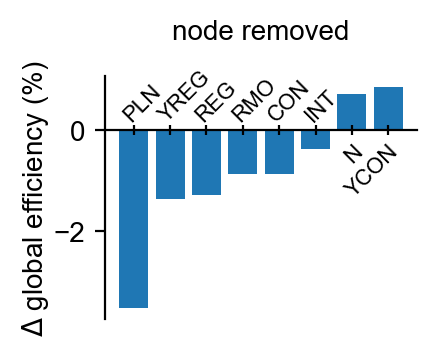

In [24]:
fig,ax = plt.subplots(
    figsize=(2,1.6)
)
ax.set_position([0.22,0.06,0.78,0.76])

y = (np.array(global_eff_fail)/global_eff-1)*100
idx = np.argsort(y)
y = y[idx]
lbl = np.array(failed_node)[idx]
x = range(len(failed_node))
ax.bar(x,y)

# Format axes
ax.spines['bottom'].set_position(('data', 0))
ax.set_xticks(x)
ax.set_xticklabels(
    lbl,
#     rotation=45,
    fontsize=8,
#     ha='left',
#     va='bottom',
#     rotation_mode='anchor',
)


for i,(g,t) in enumerate(zip(y,ax.get_xticklabels())):
    if g<0:
        t.set_ha('left')
        t.set_va('bottom')
        t.set_transform(ax.transData)
        t.set_position((i,0.2))
    else:
        t.set_ha('right')
        t.set_va('top')
        t.set_transform(ax.transData)
        t.set_position((i,-0.1))
    t.set_rotation_mode('anchor')
    t.set_rotation(45)
    

    
ax.tick_params(axis='x',direction='inout',pad=0)
ax.set_xlabel(
    'node removed',
    labelpad=-65
)

ax.set_ylabel(
    r'$\Delta$ global efficiency (%)',
    labelpad=1
)
# ax.set_xlabel(
#     'agent removed',
#     labelpad=1
# )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/pln_remove_eff.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

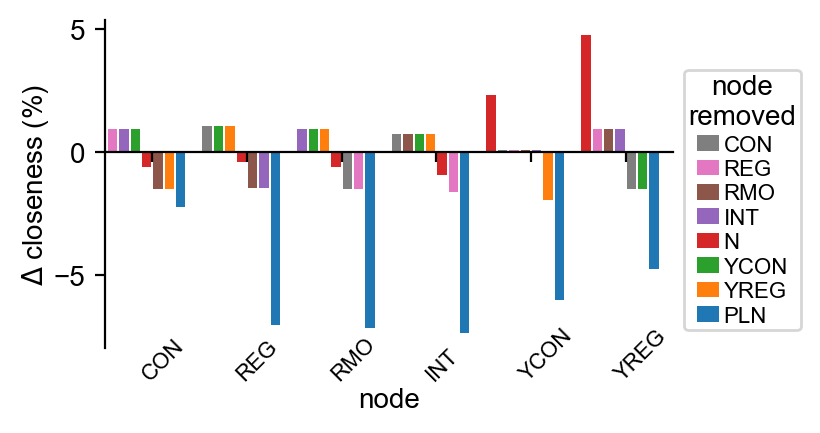

In [25]:
fig,ax = plt.subplots(
    figsize=(4,2)
)
ax.set_position([0.11,0.17,0.71,0.82])

doctors = ['CON','REG','RMO','INT',
          'YCON','YREG']

colors = cm.tab10(range(len(failed_node)))[::-1]

for i,d in enumerate(doctors):
    y = np.zeros(len(failed_node))
    for j,n in enumerate(failed_node):
        if d in node_names_fail[j]:
            idx = node_names_fail[j].index(d)
            y[j] = (close_fail[j][idx]/close[d]-1)*100
        else:
            y[j] = np.nan
    x = i + np.linspace(-0.42,0.42,8)
    idx = np.argsort(-y)
    ax.bar(x,y[idx],width=0.1,color=colors[idx])
    

# Dummy plots for legend
for j,n in enumerate(failed_node):
    ax.bar(-10,0,color=colors[j],label=failed_node[j])
ax.set_xlim([-0.5,5.5])
hleg = ax.legend(
    title='node\nremoved',
    loc='center left',
    bbox_to_anchor=(1,0.45),
    handlelength=1,
    labelspacing=0.2,
    handletextpad=0.2,
    borderpad=0.2,
    fontsize=8,
)
plt.setp(hleg.get_title(), multialignment='center')


# Format axes
ax.set_ylabel(
    r'$\Delta$ closeness (%)',
    labelpad=1
)
ax.spines['bottom'].set_position(('data', 0))
ax.set_xticks(range(len(doctors)))
ax.set_xticklabels(
    doctors,
    rotation=45,
    fontsize=8,
    ha='left',
    va='bottom',
    rotation_mode='anchor',
)
ax.tick_params(axis='x',which='major',pad=80)
ax.set_xlabel(
    'node',
    labelpad=1
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/pln_remove_close.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

### Making the system more robust
If the system is vulnerable to a compromised PLN, can it be made more robust with low cost by the addition of a small number of edges?

The specific question we ask is about interactions between doctors. The reasons for this are:
* Doctors are the clinical decision makers.
* Observations of interactions with information systems were harder to capture reliably.

We want to know if additional edges between doctors can make the network more robust to the removal of the PLN. For each edge in the set of all possible edges between doctors that don't already exist, we test the influence of that edge on global efficiency and closeness centrality. Edges are added in sequence using a greedy algorithm to maximise the increase in global efficiency.

In [26]:
added_edge = []
btwn_add = []
close_add = []
cluster_add = []
global_eff_add = []
btwn_add_fail = []
close_add_fail = []
cluster_add_fail = []
global_eff_add_fail = []

nodes = ['INT','RMO','REG','CON',
         'PLN','YREG','YCON']

for i in nodes:
    for j in nodes:
        # Rebuild the network from data
        G = nx.from_edgelist(E)
        # Is i==j?
        cond0 = i==j
        # Is (i,j) in G?
        cond1 = G.has_edge(i,j) or G.has_edge(j,i)
        # Is (i,j) forbidden?
        cond2 = ((i,j) in forbidden) or ((j,i) in forbidden)
        # Has edge already been counted?
        cond3 = (j,i) in added_edge
        if not (cond0 or cond1 or cond2 or cond3):
            # Add edge
            G.add_edge(i,j)
            added_edge.append((i,j))
            # Measure
            b = nx.betweenness_centrality(G)
            btwn_add.append(np.fromiter(b.values(),dtype=float))
            c = nx.closeness_centrality(G)
            close_add.append(np.fromiter(c.values(),dtype=float))
            cl = nx.cluster.clustering(G)
            cluster_add.append(np.fromiter(cl.values(),dtype=float))
            global_eff_add.append(nx.global_efficiency(G))
            # Remove PLN
            G.remove_node('PLN')
            G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
            if len(G_cc)>1:
                G = G.subgraph(G_cc[0])
            # Remeasure
            b = nx.betweenness_centrality(G)
            btwn_add_fail.append(np.fromiter(b.values(),dtype=float))
            c = nx.closeness_centrality(G)
            close_add_fail.append(np.fromiter(c.values(),dtype=float))
            cl = nx.cluster.clustering(G)
            cluster_add_fail.append(np.fromiter(cl.values(),dtype=float))
            global_eff_add_fail.append(nx.global_efficiency(G))

In [27]:
# Remove PLN then greedy addtion of edges to maximise global eff

# Rebuild network from edgelist
G = nx.from_edgelist(E)
# Get baseline efficiency
eff0 = nx.global_efficiency(G)

# Remove PLN
G.remove_node('PLN')
# Take Giant component
G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
if len(G_cc)>1:
    G = G.subgraph(G_cc[0])
# Create copy to unfreeze
G = G.copy()

# Nodes to test for additional edges
nodes = ['INT','RMO','REG','CON',
         'YREG','YCON'] 
# All possible edges on this subset of nodes
edges = list(combinations(nodes,2))
# Remove edges already in networke
edges = [
    e
    for e
    in edges
    if not G.has_edge(e[0],e[1])
]
 
eff = np.zeros(len(edges)+1)
eff[0] = nx.global_efficiency(G)
edge_path = []
edge_path_ties = []

# Greedy addition of edges
for i in range(len(edges)):
    eff_best = 0
    eff_test = np.zeros(len(edges))
    for j,e in enumerate(edges):
        H = G.copy()
        H.add_edge(e[0],e[1])
        eff_test[j] = nx.global_efficiency(H)
    idx = np.argwhere(eff_test==eff_test.max())
    e_best = edges[idx[0][0]]
    G.add_edge(e_best[0],e_best[1])
    edge_path.append(e_best)
    edge_path_ties.append([edges[k[0]] for k in idx])
    eff[i+1] = nx.global_efficiency(G)
    edges.remove(e_best)


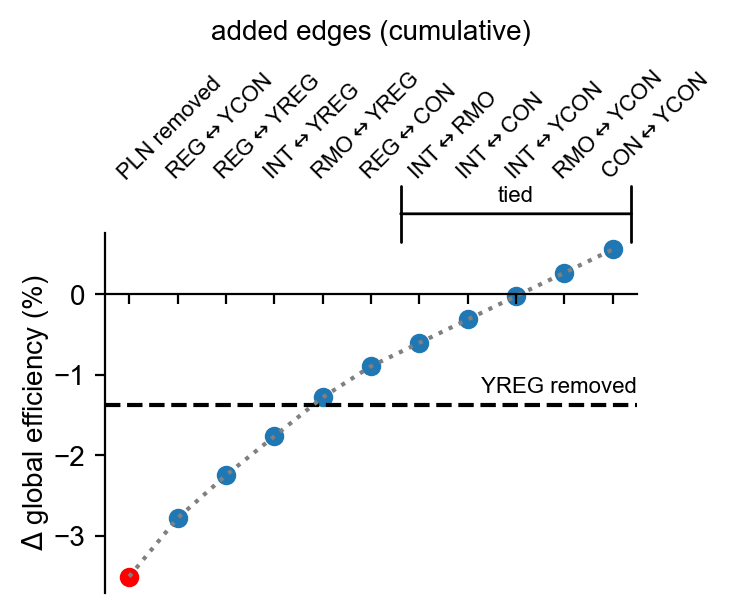

In [28]:
# Rebuild network from edgelist
G = nx.from_edgelist(E)

# Remove YREG for reference
G.remove_node('YREG')
# Take Giant component
G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
if len(G_cc)>1:
    G = G.subgraph(G_cc[0])
eff_YREG = nx.global_efficiency(G)

# Plot changes in global efficiency
fig,ax = plt.subplots(figsize=(3.5,3))

ax.set_position([0.13,0.02,0.76,0.6])

# Plot the global eff with the YREG removed for reference
y = (eff_YREG-eff0)/eff0*100
ax.axhline(y,ls='--',color='k')
s = 'YREG removed'
ax.text(
    10.5,
    y+0.1,
    s,
    va='bottom',
    ha='right',
    fontsize=8
)

x = np.arange(len(eff))
y = (eff-eff0)/eff0*100

ax.plot(x,y.T,ls=':',color='gray')
ax.scatter(x[1:],y[1:],marker='o',color=cm.tab10(0))
ax.scatter(x[0],y[0],marker='o',color='r')

# Format plot
ax.spines['top'].set_position(('data', 0))
ax.set_ylabel(
    r'$\Delta$ global efficiency (%)',
    labelpad=1
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel(
    'added edges (cumulative)',
    labelpad=10
)
ax.set_xticks(x)
ax.tick_params(axis='x',direction='in',pad=40)
ax.set_xticklabels(
     ['PLN removed'] + [r'$\leftrightarrow$'.join(a) for a in edge_path],
    rotation=45,
    ha='left',
    va='bottom',
    rotation_mode='anchor',
    fontsize=8,
)
ax.annotate(
    '',
    xy=(5.5, 1),
    xytext=(10.5,1),
    xycoords='data',
    annotation_clip=False,
    arrowprops=dict(arrowstyle="|-|", color='k')
)
ax.annotate(
    'tied',
    xy=(8., 1.1),
    xycoords='data',
    annotation_clip=False,
    ha='center',
    va='bottom',
    fontsize=8
)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/pln_addedge_eff.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

As annotated above, the last 5 edges added by the greedy algorithm are tied in terms of contribution to change in global efficiency, independent of ordering. This is confirmed by removing the PLN then adding the first 5 edges by the greedy algorithm, then test all possible permutations for adding the remaining 5 edges. These all fall on the same line as shown below.

120it [00:00, 150.63it/s]


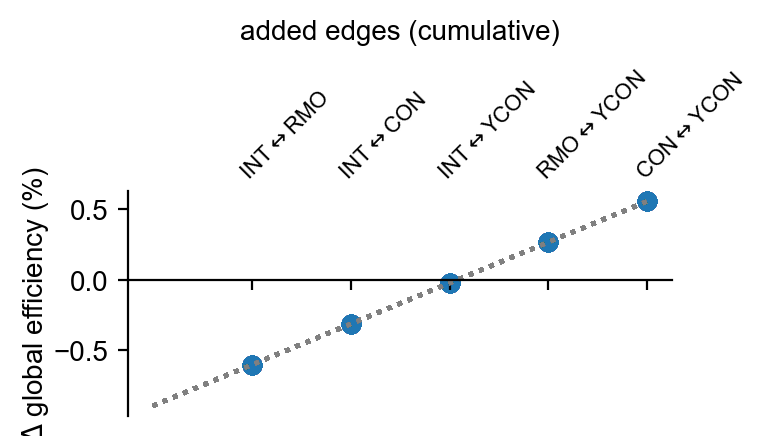

In [29]:
# Remove PLN then exhaustive addition of edges

# Rebuild network from edgelist
G = nx.from_edgelist(E)
# Get baseline efficiency
eff0 = nx.global_efficiency(G)

# Remove PLN
G.remove_node('PLN')
# Take Giant component
G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
if len(G_cc)>1:
    G0 = G.subgraph(G_cc[0])

# Plot changes in global efficiency
fig,ax = plt.subplots(figsize=(4,2.5))
ax.set_position([0.2,0.1,0.68,0.45])

efixed = [
    ('REG', 'YCON'),
    ('REG', 'YREG'),
    ('INT', 'YREG'),
    ('RMO', 'YREG'),
    ('REG', 'CON'),
]
eother = [
    ('INT', 'RMO'),
    ('INT', 'CON'),
    ('INT', 'YCON'),
    ('RMO', 'YCON'),
    ('CON', 'YCON')
]

# Greedy addition of edges
for eperm in tqdm(permutations(eother)):
    eperm = list(eperm)
    edget = efixed + eperm
    G = G0.copy()
    eff = np.zeros(len(edget)+1)
    eff[0] = nx.global_efficiency(G)
    for i,e in enumerate(edget):
        G.add_edge(e[0],e[1])
        eff[i+1] = nx.global_efficiency(G)
    y = (eff-eff0)/eff0*100
    ax.plot(x[5:],y[5:].T,ls=':',color='gray')
    ax.scatter(x[6:],y[6:],marker='o',color=cm.tab10(0))

# Format plot
ax.spines['top'].set_position(('data', 0))
ax.set_ylabel(
    r'$\Delta$ global efficiency (%)',
    labelpad=1
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel(
    'added edges (cumulative)',
    labelpad=10
)
ax.set_xticks(x[6:])
ax.tick_params(axis='x',direction='in',pad=35)
ax.set_xticklabels(
    [r'$\leftrightarrow$'.join(a) for a in eother],
    rotation=45,
    ha='left',
    va='bottom',
    rotation_mode='anchor',
    fontsize=8,
)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/pln_addedge_eff_perms.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

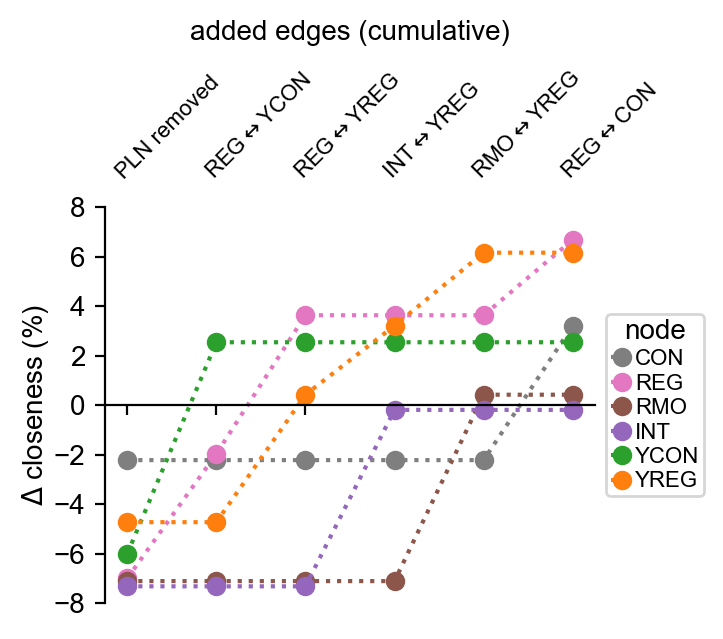

In [30]:
# Plot changes in closeness as edges added back along greedy path
fig,ax = plt.subplots(figsize=(3.5,3))
ax.set_position([0.13,0.02,0.7,0.66])
# ax.set_position([0.13,0.02,0.76,0.6])

doctors = ['CON','REG','RMO','INT',
          'YCON','YREG']

colors = cm.tab10(range(8))[::-1][[0,1,2,3,5,6],:]

for i,doc in enumerate(doctors):
    # Rebuild network from edgelist
    G = nx.from_edgelist(E)
    # Get baseline closeness
    c0 = nx.closeness_centrality(G)[doc]

    # Remove PLN
    G.remove_node('PLN')
    # Take Giant component
    G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
    if len(G_cc)>1:
        G = G.subgraph(G_cc[0])
    G = G.copy()
    
    c = np.zeros(6)
    c[0] = nx.closeness_centrality(G)[doc]
    # Add edges along greedy path for global efficiency
    for j,e in enumerate(edge_path[:5]):
        G.add_edge(e[0],e[1])
        c[j+1] = nx.closeness_centrality(G)[doc]
    
    x = np.arange(len(c))
    y = (c-c0)/c0*100
    ax.plot(y,color=colors[i],marker=('o'),ls=':',label=doc)

    
# Format plot
ax.set_ylim(-8,8)
ax.set_yticks(range(-8,9,2))
ax.spines['top'].set_position(('data', 0))
ax.set_ylabel(
    r'$\Delta$ closeness (%)',
    labelpad=1
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel(
    'added edges (cumulative)',
    labelpad=10
)
ax.set_xticks(x)
ax.tick_params(axis='x',direction='in',pad=45)
ax.set_xticklabels(
     ['PLN removed'] + [r'$\leftrightarrow$'.join(a) for a in edge_path[:5]],
    rotation=45,
    ha='left',
    va='bottom',
    rotation_mode='anchor',
    fontsize=8,
)
ax.tick_params(axis='x',which='major',pad=80)

hleg = ax.legend(
    title='node',
    loc='center left',
    bbox_to_anchor=(1,0.5),
    handlelength=1,
    labelspacing=0.2,
    handletextpad=0.1,
    borderpad=0.2,
    fontsize=8
)
plt.setp(hleg.get_title(), multialignment='center')

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/pln_addedge_close.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

<a id='decision'></a>
## Part 4: Identifying types of interactions that precipitate clinical handovers with machine learning on interaction networks
We use dynamic network features to predict patient handover from ED to EDY. Specifically, for each patient that starts in ED and is ultimately referred to EDY, w enumerate the adjacency matrix of the interaction network w.r.t the sequence of interactions. This information is encoded into a binary vector that represents the existence edges and nodes in a trajectory up to and including a given time step. These vectors are used as features in a classifier to predict referral to EDY or referral to MHOA. The classifier is used to estimate feature importance using a permutation importance test to quantify which are the most important agents and interactions for predicting a decision.

We used a Bernoulli naive Bayes classifier to identify the referral point. This model the treats existence of an agent or interaction in the trajectory (node or edge in the network, respectively) as a Bernoulli random variable that is independent of other agents or interactions.

The data are imbalanced - positive class labels only account for 23% of the data. To account for this we used random oversampling of the majority class.

To estimate feature importance including uncertainty we use a repeated group-shuffle split and permutation importance testing for 10000 splits. The permutation importance is the difference between the score for the real data and randomly permuted data. For each of the shuffle splits, we compute the permutation feature importance as the mean of this difference for 5 random permutations. We used balanced accuracy as the scoring metric.

We plot mean feature importance with error bars showing the 95% confidence interval. Note that negative permutation importance suggests that randomly permuting the variable improved classification. Hence, features with permutation scores that are often negative (such as the FILE and POL) are likely only deemed *important* in cases of over-fitting and likely will not generalise as good predictors.

These results are visualised on the network. Node size and edge width correspond to the probability that we observe said node or edge prior to referral to EDY. Color shows feature importance.

In [31]:
# Get network but remove all edges
G = nx.from_edgelist(E)
G_empty = nx.create_empty_copy(G)
# Extract adjacency time series for each patient
PT = T['ID'].unique()
ADJ = []
interaction_count=0
for pt in PT:
    G = G_empty.copy()
    idx = T['ID'] == pt
    TT = T[idx].copy()
    # Trajectory must start in ED
    if TT['TEAM'].iloc[0] != 'ED':
        continue
    # Trajectory must include referral to EDY
    actions = ''.join(TT['ACTION'])
    if not ('REF EDY' in actions):
        continue
    A = []
    # Loop over steps in trajectory
    for agents,stored,accessed,action in zip(TT['AGENTS'].to_list(),
                                      TT['STORED'].to_list(),
                                      TT['ACCESSED'].to_list(),
                                      TT['ACTION'].to_list()):
        interaction_count += 1
        a = agents.split()
        if isinstance(stored,str):
            a += stored.split()
        if isinstance(accessed,str):
            a += accessed.split()
        a = list(set(a))
        a.sort() # edges are bi-directional so sorting makes filtering easier
        for pair in combinations(a,2):
            if pair not in forbidden:
                G.add_edge(pair[0],pair[1]) # Unweighted network
#                 if G.has_edge(pair[0],pair[1]):
#                     G[pair[0]][pair[1]]['weight'] += 1
#                 else:
#                     G.add_edge(pair[0],pair[1],weight=1)
        # Save adjacency matrix
        A.append(nx.to_numpy_array(G))
        # Stop if referral has been made
        if any([dec in action for dec in ['REF EDY','REF MHOA']]):
            break
    ADJ.append(A)


In [32]:
# Format dataset for sklearn - features are nodes and edges
X = []
Y = []
GRP = []
for i,A in enumerate(ADJ):
    x = []
    for a in A:
        edges = np.tril(a).flatten()
        nodes = a.any(axis=1)
        x.append(np.hstack([edges,nodes]))
#         x.append(nodes)
    y = np.zeros(len(x))
    y[-1] = 1
    grp = np.ones(len(x))*i
    X.append(np.array(x))
    Y.append(y)
    GRP.append(grp)
X = np.vstack(X)
y = np.hstack(Y)
groups = np.hstack(GRP)

# Get agents for edges and nodes
agents = np.array(list(G.nodes))
labels = np.zeros((len(agents),len(agents)),dtype=object)
label_index = []
for i,a in enumerate(agents):
    for j,b in enumerate(agents):
        labels[i,j] = a+r'$\leftrightarrow$'+b
        label_index.append((a,b))
labels = np.tril(labels).flatten()
labels = list(labels) + list(agents)



# Remove features that are static
idx = X.any(axis=0)
X = X[:,idx]
agent_labels = [lbl for i,lbl in enumerate(labels) if idx[i]]
label_index = [lbl for i,lbl in enumerate(label_index) if idx[i]]

In [33]:
clf = BernoulliNB()

accuracy = []
balanced_accuracy = []
precision = []
recall = []
f1 = []
importances = []
perm = []

gss = GroupShuffleSplit(n_splits=10000,test_size=0.2)
for train_index,test_index in tqdm(gss.split(X, y, groups)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ros = RandomOverSampler(random_state=0)
    X_resampled,y_resampled = ros.fit_resample(X_train, y_train)
    
    clf.fit(X_resampled,y_resampled)
    
    y_pred = clf.predict(X_test)
    
    accuracy.append(accuracy_score(y_test,y_pred))
    balanced_accuracy.append(balanced_accuracy_score(y_test,y_pred))
    precision.append(precision_score(y_test,y_pred,zero_division=0))
    recall.append(recall_score(y_test,y_pred))
    f1.append(f1_score(y_test,y_pred))
#     importances.append(clf.feature_importances_)
    p = permutation_importance(clf,X_test,y_test,scoring='balanced_accuracy',n_repeats=5,n_jobs=-1)
    perm.append(p['importances_mean'])


10000it [25:25,  6.56it/s]


In [34]:
print('Model performance\n')
print(f'Accuracy: {np.mean(accuracy):.2f},' + 
      f' [{np.percentile(accuracy,q=[2.5])[0]:.2f},' +
     f' {np.percentile(accuracy,q=[97.5])[0]:.2f}]')

print(f'Balanced accuracy: {np.mean(balanced_accuracy):.2f},' + 
      f' [{np.percentile(balanced_accuracy,q=[2.5])[0]:.2f},' +
     f' {np.percentile(balanced_accuracy,q=[97.5])[0]:.2f}]')

print(f'Precision: {np.mean(precision):.2f},' + 
      f' [{np.percentile(precision,q=[2.5])[0]:.2f},' +
     f' {np.percentile(precision,q=[97.5])[0]:.2f}]')

print(f'Recall: {np.mean(recall):.2f},' + 
      f' [{np.percentile(recall,q=[2.5])[0]:.2f},' +
     f' {np.percentile(recall,q=[97.5])[0]:.2f}]')

print(f'f1 score: {np.mean(f1):.2f},' + 
      f' [{np.percentile(f1,q=[2.5])[0]:.2f},' +
     f' {np.percentile(f1,q=[97.5])[0]:.2f}]')

Model performance

Accuracy: 0.85, [0.62, 1.00]
Balanced accuracy: 0.82, [0.58, 1.00]
Precision: 0.74, [0.31, 1.00]
Recall: 0.73, [0.25, 1.00]
f1 score: 0.71, [0.33, 1.00]


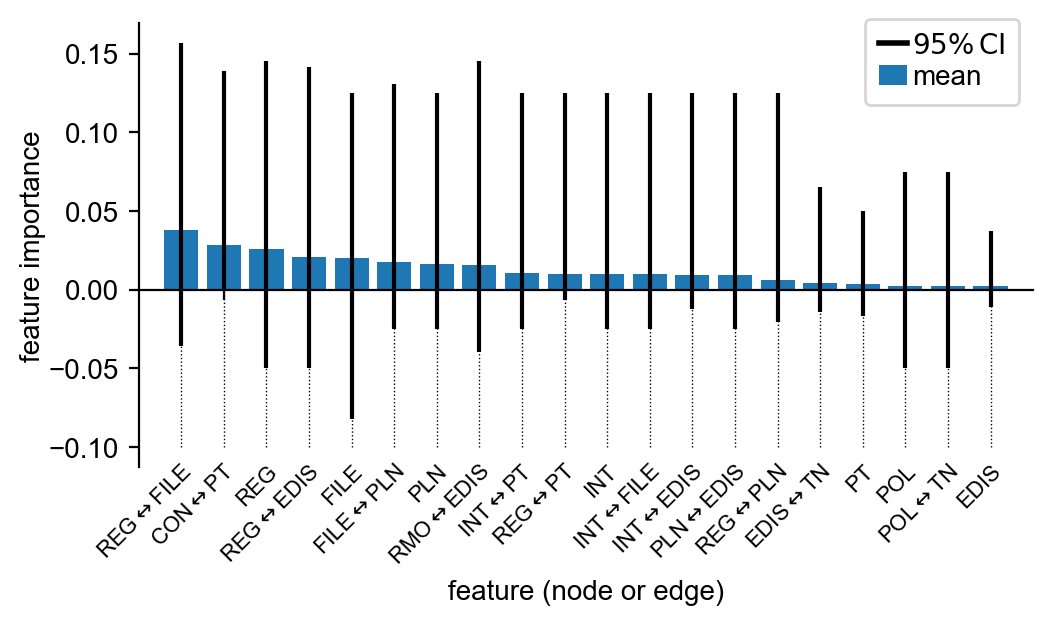

In [35]:
# Plot the top 20 importances
n=20

# Draw
fig,ax = plt.subplots(
    figsize=(5.2,3),
)
ax.set_position([0.12,0.24,0.86,0.74])
importances = np.vstack(perm)
y = np.mean(importances,axis=0)
yci = np.percentile(importances,q=[2.5,97.5],axis=0)
yerr = np.abs(y-yci)
x = np.arange(y.shape[0])
idx = np.argsort(-y)[:n]
ax.bar(x[:n],y[idx],yerr=yerr[:,idx],label='mean')
ax.plot(0,0,c='k',lw=2,label=r'$\mathsf{95\%\,CI}$')

# Format plot
ax.set_xlim(x[0]-1,x[19]+1)
ax.spines['bottom'].set_position(('data', 0))
ax.set_xticks(x[:n])
ax.set_xticklabels(
    np.array(agent_labels)[idx][:n],
    rotation=45,
    rotation_mode='anchor',
    ha='right',
    fontsize=8,
)
ax.tick_params(axis='x',
               which='major',
               pad=58)
ax.vlines(x[:n],-0.1,0,colors='k',ls=':',lw=0.5)
ax.set_ylabel(
    'feature importance',
    labelpad=1
)
ax.set_xlabel(
    'feature (node or edge)',
    labelpad=4
)

ax.legend(
    loc='upper right',
    bbox_to_anchor=[1,1.04],
    handlelength=1,
    labelspacing=0.2,
    handletextpad=0.2,
    borderpad=0.5
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save figure
fname = "figs/predict_importance.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)

/tmp/ipykernel_353/4170424921.py:54: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(


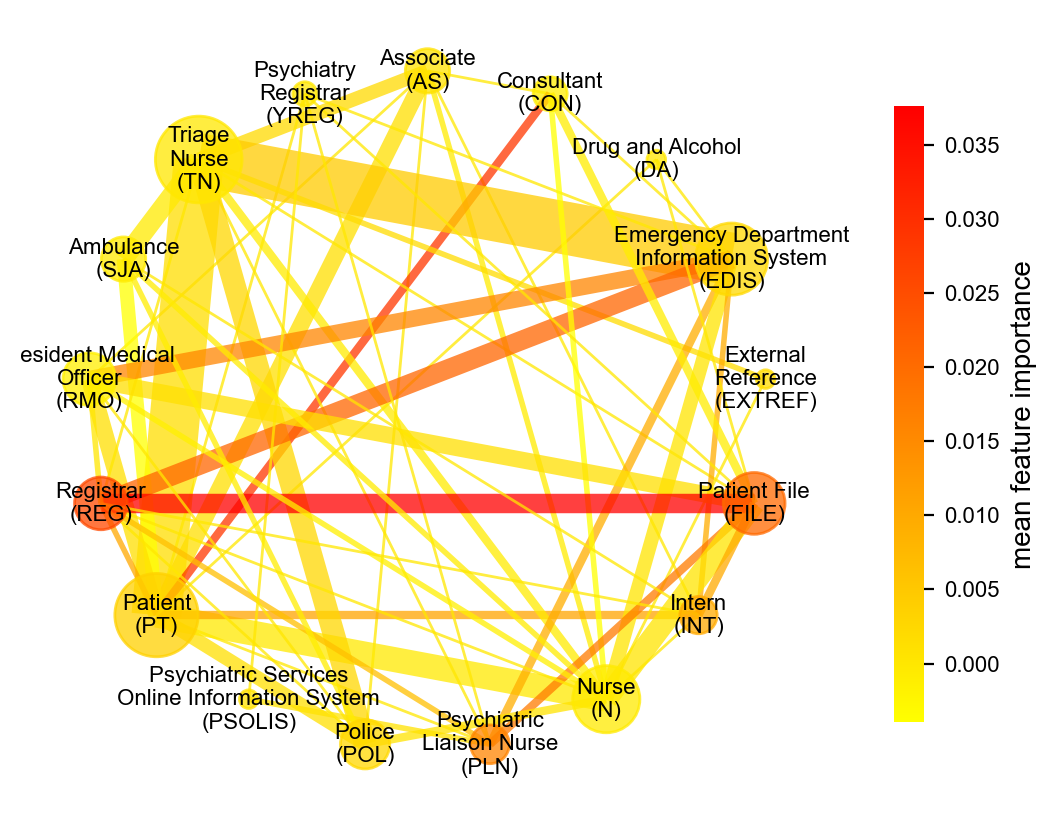

In [36]:
# Plot the *average* network at the decision point

# Get average network
AV = []
for A in ADJ:
    AV.append(A[-1])
AV = np.array(AV)
A = AV.mean(axis=0)
G = nx.from_numpy_array(A)
mp = {i:a for i,a in enumerate(agents)}
G = nx.relabel_nodes(G, mp, copy=True)
G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(G_cc[0])

# Add importances
attr_dict = {}
y = np.mean(importances,axis=0)
for j,imp in enumerate(y):
    if j<len(label_index):
        G[label_index[j][0]][label_index[j][1]]['importance'] = imp
    else:
        attr_dict[agent_labels[j]] = imp

# attr_dict = {a:imp for a,imp in zip(agents,y[-len(agents):])}
nx.set_node_attributes(G,attr_dict,name='importance')

# Draw
fig,ax = plt.subplots(
    figsize=(5.2,4),
)

pos = nx.circular_layout(sorted(G.nodes()))
pos = {label_dict[a].replace(r'\n','\n') + f'\n({a})':p[::-1] for a,p in pos.items()}
mp = {a:label_dict[a].replace(r'\n','\n') + f'\n({a})' for a in agents}
G = nx.relabel_nodes(G, mp, copy=True)

# Get labels/weights etc/
node_weights = np.array(list(dict(G.degree(weight='weight')).values()))
node_imp = list(nx.get_node_attributes(G, 'importance').values())
weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))*20
edge_imp = list(nx.get_edge_attributes(G, 'importance').values())

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=node_weights*300,
    node_color=node_imp,
    alpha=0.75,
    cmap=cm.autumn_r
)
nodes.set_clim(y.min(),y.max())

edges = nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    width=weights,
    edge_color=edge_imp,
    alpha=0.75,
    edge_cmap=cm.autumn_r
)
edges.set_clim(y.min(),y.max())

nx.draw_networkx_labels(
    G,
    pos,
    font_size=8,
    font_color='k',
    font_family='sans-serif',
    font_weight='normal',
    alpha=None,
    bbox=None,
    horizontalalignment='center',
    verticalalignment='center',
    ax=ax,
)
sm = plt.cm.ScalarMappable(cmap=cm.autumn_r, norm=plt.Normalize(vmin=y.min(), vmax=y.max()))
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax,anchor=(0.65,0.5))
cbar.set_label('mean feature importance')
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)


# Format axes
ax.set_position([0,0,0.8,1])
ax.axis('off')
ax.set_xlim(-1.2,1.25)
ax.set_ylim(-1.15,1.15)
ax.set_aspect('equal')

# Save figure
fname = "figs/predict_net.pdf"
fig.savefig(
    fname,
    format='pdf',
#     bbox_inches='tight',
#     pad_inches=0,
)